# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Problem Statement
Build a machine learning model predicting offer success based on the demographic information and the offer details that are provided in the data.

Answer following questions:

* Which offer is the most successful?
* Who spends more money? male or female?

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = 'whitegrid')


import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

**I) Portfolio data - offer information.**

First, let's take a quick look at the different offers in the portfolio.

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


# Cleaning Portfolio data:

* Check the categorical data type columns to plan on how to clean them.
* Create dummies for the channels (different type of offer campaigns).
* Create dummies on the offer_type.
* Concat these dummies values and drop the original columns.

In [4]:
print(f"There are {portfolio['id'].nunique()} unique offers in the portfolio.")
print("These are distributed among the offer types as follows")
portfolio.offer_type.value_counts()

There are 10 unique offers in the portfolio.
These are distributed among the offer types as follows


bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

The different channels as well as the offer types need to be represented differently for analysis. so should Convert categorical variable into indicator variables.

In [5]:
# clean channels
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, channels], axis=1)
# drop column channel
portfolio.drop(['channels'], axis=1, inplace=True)
portfolio['offer'] = (portfolio['offer_type'] + "_" + portfolio['reward'].astype('str')
                          + "_for_" + portfolio['difficulty'].astype('str') + "_in_"
                          + portfolio['duration'].astype('str') + "days")
portfolio

C:\Users\radel\AppData\Local\Temp\ipykernel_20896\2878173229.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)


,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_for_10_in_7days
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_for_10_in_5days
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_for_0_in_4days
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_for_5_in_7days
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_for_20_in_10days
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_for_7_in_7days
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_for_10_in_10days
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_for_0_in_3days
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_for_5_in_5days
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_for_10_in_7days


In [6]:
# clean offer types
offer_types = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, offer_types], axis=1)
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,offer,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_for_10_in_7days,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_for_10_in_5days,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_for_0_in_4days,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_for_5_in_7days,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_for_20_in_10days,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_for_7_in_7days,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_for_10_in_10days,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_for_0_in_3days,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_for_5_in_5days,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_for_10_in_7days,0,1,0


**II) Profile data - customer information.**

Next, let's take a look at the demographic customer data

In [7]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


# Cleaning Profile data

* Check how many data entries are missing values.
* Check the customers' gender and income values for missing values.
* Create a datetime format for became_member_on column data.
* Find the total number of days a customer has been a member, assigned to membership_duration column.
* Rename the column id to customer_id and reindex columns_order.

In [8]:
profile.isnull().sum()*100/len(profile)

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [9]:
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


It is interesting to see for every gender with value None, the income is also unknown.

Also when both are unknown, age is set to 118 for all the rows with NaN values.

And missing values is roughly 12.8%, as this is less percentage, my strategy is to drop those for the machine learning model. Thus, I am not considering for implementing an imputation strategy here.

In [10]:
profile.dropna(inplace=True)

In [11]:
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head(10)

,gender,age,id,became_member_on,income


In [12]:
# calculate membership duration
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_duration'] = (datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days
profile.head(10)

,gender,age,id,became_member_on,income,membership_duration
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2001
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2068
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1716
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1792
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1882
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,1943
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,3249
15,F,62,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,2521
16,M,49,62cf5e10845442329191fc246e7bcea3,2014-11-13,52000.0,2976
18,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,1832


In [13]:
profile = profile.rename(columns = {'id': 'customer_id'})
columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on', 'membership_duration']
profile = profile.reindex(columns = columns_order)
profile = profile.reset_index(drop=True)
profile.head()

,customer_id,gender,age,income,became_member_on,membership_duration
0,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,2017-07-15,2001
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,2068
2,e2127556f4f64592b11af22de27a7932,M,68,70000.0,2018-04-26,1716
3,389bc3fa690240e798340f5a15918d5c,M,65,53000.0,2018-02-09,1792
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,2017-11-11,1882


Just curious to know how membership is increasing every year. So lets plot a line graph to see number of membership every year.

<AxesSubplot:xlabel='became_member_on'>

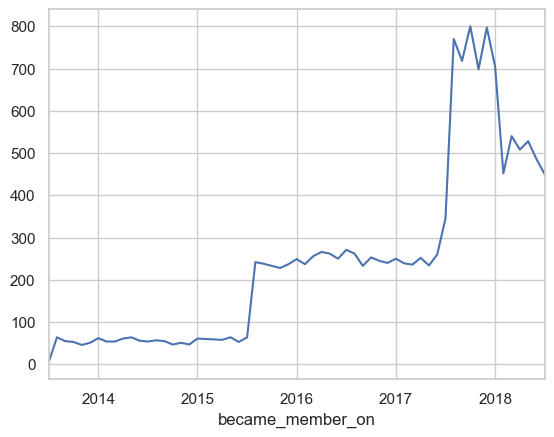

In [14]:
profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count().plot.line()

The distribution plot of their income, age, and days of membership based on their genders needs to be explored and visualized. for this, can write a function plot_profile() to reduce repeating code of writing 3 times.

In [15]:
def plot_profile(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    ''' 
    sns.set(style = 'whitegrid', font_scale = 1.25)
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)
    
    plt.sca(ax[0])
    sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
    plt.title('Female\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[df['gender'] == 'M'][variable], bins = 10, color = palette[1]);
    plt.title('Male\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')

    plt.sca(ax[2])
    sns.distplot(df[df['gender'] == 'O'][variable], bins = 10, color = palette[2]);
    plt.title('Other\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.show()
    
    return plt

C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

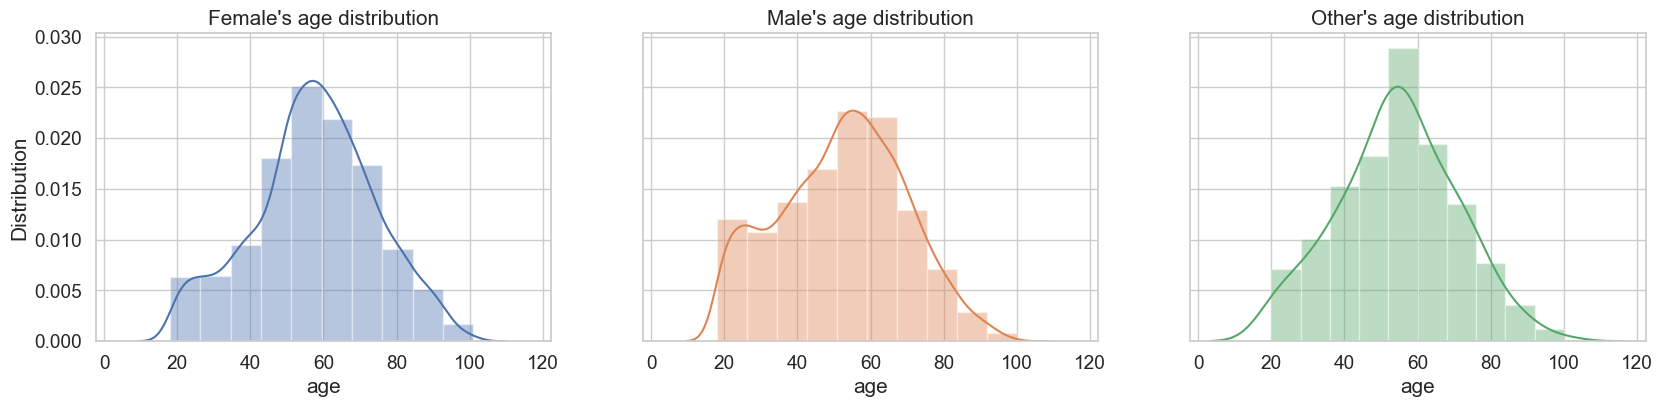

In [16]:
age_plot = plot_profile(profile, 'age')

C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

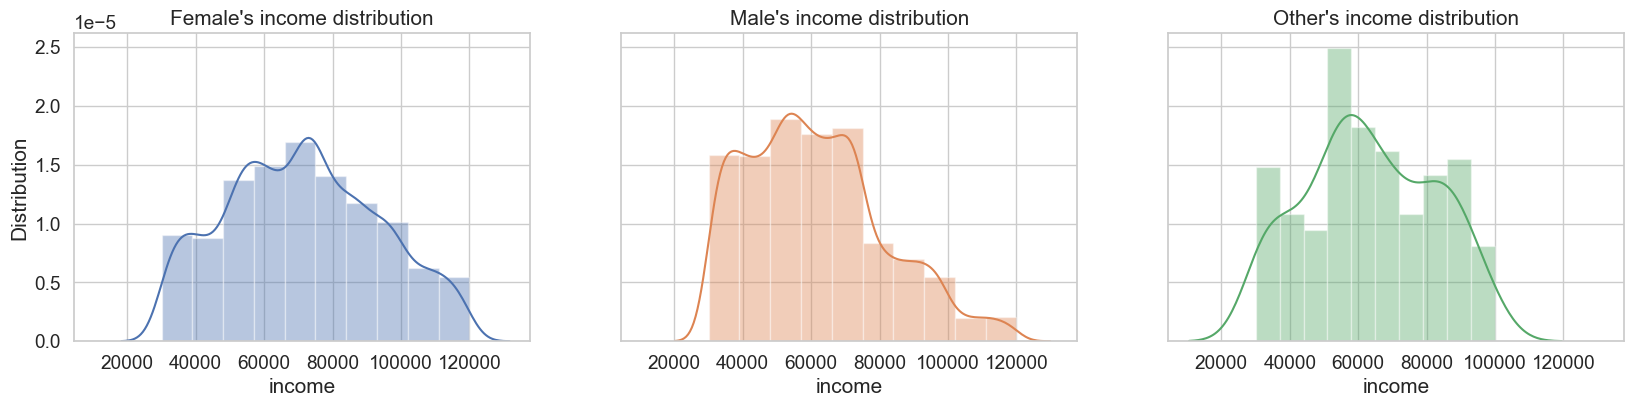

In [17]:
income_plot = plot_profile(profile, 'income')

C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\radel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

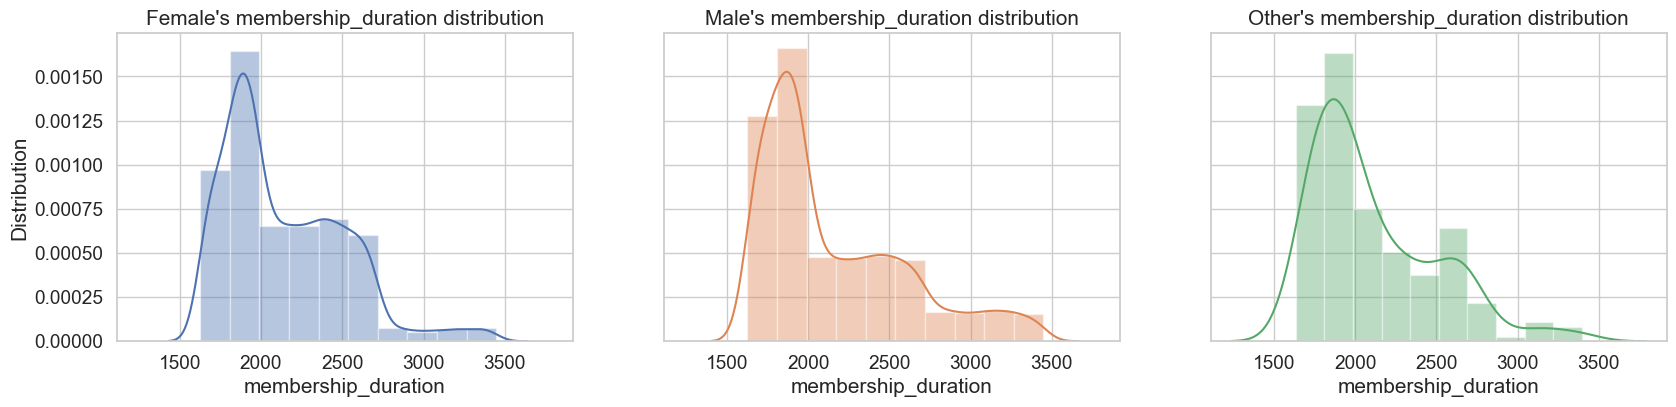

In [18]:
membership_duration_plot = plot_profile(profile, 'membership_duration')

**III) Transcript data - events**

Finally, let's take a look at the actual offer and transaction events.

In [19]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [20]:
# unique events types
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [21]:
# number of each events
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [22]:
len(transcript)

306534

In [23]:
# I am planning to keep only data in transcript which has customer id in profile dataframe.
temp2 = transcript['person'].isin(profile['customer_id'])
transcript = transcript[temp2]
print(len(transcript))
transcript.head(10)

272762


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
13,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
14,d53717f5400c4e84affdaeda9dd926b3,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
15,f806632c011441378d4646567f357a21,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0


I am planning to have a separate dataframe which has details about customer id and Amount spent by each customer. I am calling that dataframe moneyspent.

In [24]:
# amount spent is mentioned for only data with event = transaction, so filtering that.
df_trans = transcript[transcript['event']=='transaction']
moneyspent = pd.DataFrame(data=df_trans)
moneyspent = moneyspent.drop(['value', 'event'], axis = 1)
# taing out amount from value column
moneyspent['amount'] = df_trans['value'].apply(lambda x: list(x.values())[0])
moneyspent = moneyspent.rename(columns = {'person': 'customer_id'})
moneyspent = moneyspent.reset_index(drop=True)
moneyspent.head()

,customer_id,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


# Who spends more money? male or female?

In [25]:
moneyspent = pd.merge(moneyspent, profile[['gender','customer_id']], how='left', on='customer_id')
moneyspent.head()

,customer_id,time,amount,gender
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,M
2,54890f68699049c2a04d415abc25e717,0,13.23,M
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,F
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,F


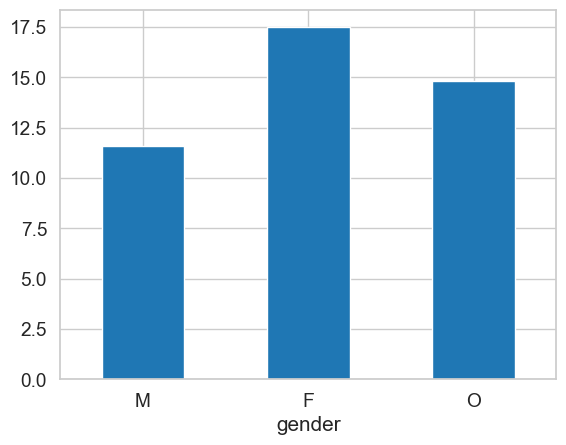

In [26]:
gender_groupby = moneyspent.groupby('gender')
gender_transactions = gender_groupby.amount.count()
gender_expense = gender_groupby.amount.sum()
(gender_expense / gender_transactions).reindex(['M', 'F','O']).plot(kind='bar', rot=0, color='tab:blue');

**By the filtering based on gender we see that women spend more money in general :D**

In [27]:
# Create function to retrieve offer_id from feature value
def offer_id(x):
    for key,value in x.items():
        if key in ['offer id','offer_id']:
            return str(value)

In [28]:
# Create column 'offer_id' and applying the function offer_id
transcript['offer_id'] = transcript['value'].apply(offer_id)
transcript['amount'] = df_trans['value'].apply(lambda x: list(x.values())[0])

In [29]:
transcript.head()

,person,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [30]:
# calculate number of offers received per person  and save in num_offers
num_offers = transcript[transcript['event']=='offer received'].groupby('person').count().reset_index()
num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
transcript = pd.merge(transcript, num_offers[['person', 'num_offers']], how='left', on='person')
transcript.head()

,person,event,value,time,offer_id,amount,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,4.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0


In [31]:
# convert event_types categorical variable into indicator variables
event_types = pd.get_dummies(transcript.event)
transcript = pd.concat([transcript, event_types], axis=1)
transcript.head()

,person,event,value,time,offer_id,amount,num_offers,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,4.0,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0,0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3.0,0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,0,1,0,0


In [32]:
# drop and rename columns
transcript.drop(['value'], axis=1, inplace=True)
transcript.rename(columns={'person':'customer_id'},inplace=True)
transcript.head(3)

,customer_id,event,time,offer_id,amount,num_offers,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,4.0,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0,0,1,0,0


# Just filter based on 1 customerId to understand how the event data of each customer look like and which factors need to be addressed during the analysis

In [33]:
transcript[transcript['customer_id']=='0009655768c64bdeb2e877511632db8f']

,customer_id,event,time,offer_id,amount,num_offers,offer completed,offer received,offer viewed,transaction
49809,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,5.0,0,1,0,0
68958,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,5.0,0,0,1,0
79398,0009655768c64bdeb2e877511632db8f,transaction,228,None,22.16,5.0,0,0,0,1
101124,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,5.0,0,1,0,0
124382,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,5.0,0,0,1,0
136377,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,0,1,0,0
149533,0009655768c64bdeb2e877511632db8f,transaction,414,None,8.57,5.0,0,0,0,1
149534,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,1,0,0,0
166743,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,0,0,1,0
181758,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,5.0,0,1,0,0


In [34]:
#Combine transcript and portfolio data based on offer_id, so that we have one combined data for analysis.
combined = pd.merge(transcript, portfolio, how='left', on='offer_id')
combined.groupby(['offer_type', 'event']).customer_id.count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

In [35]:
combined.head()

,customer_id,event,time,offer_id,amount,num_offers,offer completed,offer received,offer viewed,transaction,...,duration,offer_type,email,mobile,social,web,offer,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0,0,1,0,0,...,7.0,bogo,1.0,1.0,0.0,1.0,bogo_5_for_5_in_7days,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,4.0,0,1,0,0,...,7.0,discount,1.0,1.0,0.0,1.0,discount_2_for_10_in_7days,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0,0,1,0,0,...,5.0,bogo,1.0,1.0,1.0,1.0,bogo_5_for_5_in_5days,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,3.0,0,1,0,0,...,4.0,informational,1.0,1.0,0.0,1.0,informational_0_for_0_in_4days,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,0,1,0,0,...,10.0,discount,1.0,0.0,0.0,1.0,discount_5_for_20_in_10days,0.0,1.0,0.0


C:\Users\radel\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


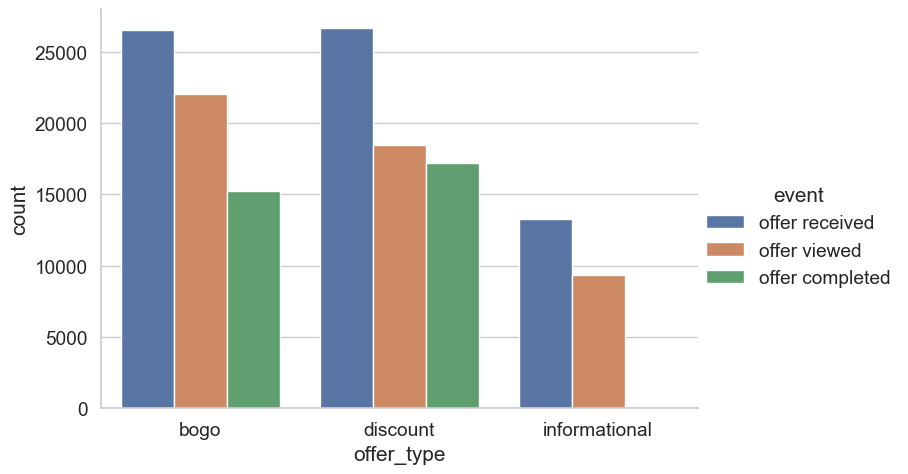

In [36]:
#Plot a graph to see each event by offer_type
events_by_offer_type = sns.factorplot(data=combined[combined['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5)

# Data Preparation
Inorder to give data to model and get good result, present data we have is not enough.
It is done with basic cleaning but its not prepared to give to model.

I will have a separate column to define which outcomes in the data can be classified as success cases.
As BOGO and discount offers have 'offer completed' events while informational offers have not, I prepare data for the offer types separately, starting out with BOGO and discount offers.

**BOGO and Discount Offers In general, possible event paths for BOGO and discount offers are:**

* 1) successful offer: offer received → offer viewed → transaction(s) → offer completed
* 2) ineffective offer: offer received → offer viewed
* 3) unviewed offer: offer received
* 4) unviewed success: offer received → transaction(s) → offer completed

While successful offer is the path that reflects that an offer was successfully completed after viewing it that is what we want(desirable outcome)
both ineffective offer and unviewed offer reflect that the offer was not successful, i.e., did not lead to transactions by the customer (or to insufficient transactions).This can be treated as failure of offer.
However, it is important to keep in mind that there can also be unviewed success cases, meaning that the customer has not viewed the offer, but completed it anyways, i.e., that the customer made transactions regardless of the offer. Thus it is very much important to separate unviewed success from successful offer, so that targeting right customers can be achieved.

Ideally, Starbucks might want to target those customer groups that exhibit event path 1, while not targeting those that are most likely to follow paths 2 and 3 because those are not going to make transactions
or 4 because those make transactions anyways, so Starbucks would actually lose money by giving them discounts or BOGO offers.

In [37]:
def prepare_offer_completion(df):
    '''
    cleans dataframe for further analysis based on offer completion
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    combined - the cleaned dataframe
    
    ''' 
    pd.options.mode.chained_assignment = None
    
    # identify success cases in 'offer completed' rows
    offers_completed = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']].sort_values(['customer_id','time'])
    offers_completed = offers_completed[(offers_completed['event']=='offer viewed') | (offers_completed['event']=='offer completed')]
    
    
    # shift() - what this does now shifts first row to next row and put as first row as NaN. way it performs depends on condition.
    # Using this we can filter groups based on customer id and offer_id, and apply shift() to have reference offer_id in column previous_offer_id
    #this is helpful when filtering based on offer completed, so that we get success cond, where offer is completed and that is viewed.
    offers_completed['previous_offer_id'] = offers_completed.groupby(['customer_id', 'offer_id'])['offer_id'].shift()
    
    
    # if offer is completed and if it is viewed then put 1 or else 0 in success column. 
    offers_completed['success'] = np.where((offers_completed['event'] == 'offer completed')
                                           & (offers_completed['previous_offer_id'] == offers_completed['offer_id']),
                                           1, 0)
    # if offer is completed and if it is not viewed then put 1 or else 0 in unviewed success column. 
    offers_completed['unviewed_success'] = np.where((offers_completed['event'] == 'offer completed')
                                                    & (offers_completed['previous_offer_id'].isna()),
                                                    1, 0)
    offers_completed.drop(['previous_offer_id'], axis=1, inplace=True)
    
    # re-include 'offer received' rows
    received_offers = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']][df['event']=='offer received'].sort_values(['customer_id','time'])
    
    together = received_offers.append(offers_completed).sort_values(['customer_id','time'])
    together = together.sort_values(['customer_id','time'])
    
    # transmit information from 'offer completed' to corresponding 'offer received' rows
    successes = together[(together['event']=='offer received') | (together['event']=='offer completed')]
    successes['success'] = successes.groupby(['customer_id', 'offer_id'])['success'].bfill()
    successes['unviewed_success'] = successes.groupby(['customer_id', 'offer_id'])['unviewed_success'].bfill()
    result = successes[successes['event']=='offer received']
    
    # classify remaining offers as failures and fill missings
    result['failure'] = np.where((result['success'].isna()) & (result['unviewed_success'].isna()), 1, 0)
    # fill missing values with 0
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    
    result['success'] = result['success'].astype('int')
    result['unviewed_success'] = np.where(result['unviewed_success'].isna(), 0, result['unviewed_success'])
    result['unviewed_success'] = result['unviewed_success'].astype('int')
    
    # build categorical outcome column
    result['outcome'] = np.where(result['success'] == 1, 'success',
                                 np.where(result['unviewed_success'] == 1, 'unviewed success', 'failure'))

    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    # add customer and offer information
    combined = pd.merge(result, portfolio, how='left', on='offer_id')
    combined = pd.merge(combined, profile, how='left', on='customer_id')
    combined.drop(['event', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return combined

In [38]:
bogo = combined[combined['offer_type']=='bogo']
discount = combined[combined['offer_type']=='discount']
bogo_discount_notcleaned = bogo.append(discount)

C:\Users\radel\AppData\Local\Temp\ipykernel_20896\121361470.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bogo_discount_notcleaned = bogo.append(discount)


In [39]:
bogo_cleaned = prepare_offer_completion(bogo)
discount_cleaned = prepare_offer_completion(discount)
bogo_discount = bogo_cleaned.append(discount_cleaned)
bogo_discount.head(10)

C:\Users\radel\AppData\Local\Temp\ipykernel_20896\1503442076.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  together = received_offers.append(offers_completed).sort_values(['customer_id','time'])
C:\Users\radel\AppData\Local\Temp\ipykernel_20896\1503442076.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  together = received_offers.append(offers_completed).sort_values(['customer_id','time'])
C:\Users\radel\AppData\Local\Temp\ipykernel_20896\523442905.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bogo_discount = bogo_cleaned.append(discount_cleaned)


,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,social,web,offer,bogo,discount,informational,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,33,72000.0,2086
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,1,0,0,O,40,57000.0,1823
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,0,bogo_10_for_10_in_7days,1,0,0,F,59,90000.0,2499
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10,...,1,1,bogo_10_for_10_in_5days,1,0,0,F,59,90000.0,2499
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,F,24,60000.0,2247
5,0020ccbbb6d84e358d3414a3ff76cffd,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,1,0,0,F,24,60000.0,2247
6,004b041fbfe44859945daa2c7f79ee64,504,f19421c1d4aa40978ebb69ca19b0e20d,3.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,F,55,74000.0,1704
7,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,1,0,unviewed success,1,10,...,1,0,bogo_10_for_10_in_7days,1,0,0,M,54,99000.0,2472
8,004c5799adbf42868b9cff0396190900,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,54,99000.0,2472
9,004c5799adbf42868b9cff0396190900,504,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,54,99000.0,2472


In [40]:
def prepare_offer_info_tranx(df):
    '''
    cleans dataframe for further analysis based on transactions within validity period
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    temp3 - the cleaned dataframe
    
    ''' 
    temp3 = df.sort_values(['customer_id','time'])

    # calculate remaining time for offers
    temp3['duration_hrs'] = temp3.duration * 24
    
    # if offer recieved then temp3['time'] + temp3['duration_hrs'] or nan
    temp3['end_time'] = np.where(temp3['event']=='offer received', temp3['time'] + temp3['duration_hrs'], np.nan)
    temp3['end_time'] = temp3.groupby('customer_id')['end_time'].ffill()
    temp3['remaining'] = temp3['end_time'] - temp3.time
    
    temp3['offer'] = np.where((temp3['event']=='transaction') & (temp3['remaining']>=0), temp3['offer'].ffill(), temp3.offer)

    # get rid of all transactions that do not belong to an offer
    temp3 = temp3[-temp3['offer'].isna()]


    # calculate transaction sum during offer validity period using transactions and offer viewed
    temp3_rest = temp3[(temp3['event']=='offer viewed')|(temp3['event']=='transaction')]
    uff = pd.DataFrame(temp3_rest.groupby(['customer_id','offer'])['amount'].sum())
    uff.rename(columns={'amount':'sum'},inplace=True)
    temp3_rest_sum = pd.merge(temp3_rest, uff, how='left', on=['customer_id','offer'])
    temp3_rest_sum['amount'] = np.where(temp3_rest_sum['event']=='offer viewed', temp3_rest_sum['sum'], temp3_rest_sum['amount'])
    temp3 = temp3[temp3['event']=='offer received'].append(temp3_rest_sum).sort_values(['customer_id','time'])
    temp3 = temp3.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # transfer transaction sum to 'offer received' rows
    temp3 = temp3[-(temp3['event']=='transaction')]
    temp3['amount'] = temp3.groupby(['customer_id','offer'])['amount'].shift(-1)
    temp3 = temp3[temp3['event']=='offer received']
    temp3['amount'] = temp3['amount'].fillna(0)
    
    # add success indicator
    temp3['success'] = np.where(temp3['amount']>0,1,0)
    temp3['unviewed_success'] = -99
    temp3['failure'] = -99
    temp3['outcome'] = -99
    temp3['outcome_factor'] = -99
    
    # add customer information
    temp3 = pd.merge(temp3, profile, how='left', on='customer_id')
    temp3.drop(['event', 'became_member_on'], axis=1, inplace=True)

    return temp3

In [41]:
info = combined[(combined['offer_type']=='informational') |(combined['event']=='transaction')]

In [42]:
info_cleaned = prepare_offer_info_tranx(info)
info_cleaned.head(10)

C:\Users\radel\AppData\Local\Temp\ipykernel_20896\2801816556.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp3 = temp3[temp3['event']=='offer received'].append(temp3_rest_sum).sort_values(['customer_id','time'])


,customer_id,time,offer_id,amount,num_offers,offer completed,offer received,offer viewed,transaction,reward,...,informational,success,unviewed_success,failure,outcome,outcome_factor,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,22.16,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,M,33,72000.0,2086
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,8.57,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,M,33,72000.0,2086
2,0011e0d4e6b944f998e987f904e8c1e5,0,3f207df678b143eea3cee63160fa8bed,0.00,5.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,O,40,57000.0,1823
3,0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,0.00,5.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,O,40,57000.0,1823
4,0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,51.10,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,59,90000.0,2499
5,0020ccbbb6d84e358d3414a3ff76cffd,408,5a8bc65990b245e5a138643cd4eb9837,58.87,4.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,24,60000.0,2247
6,003d66b6608740288d6cc97a6903f4f0,0,5a8bc65990b245e5a138643cd4eb9837,2.51,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,26,73000.0,2025
7,003d66b6608740288d6cc97a6903f4f0,336,3f207df678b143eea3cee63160fa8bed,12.27,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,26,73000.0,2025
8,00426fe3ffde4c6b9cb9ad6d077a13ea,0,5a8bc65990b245e5a138643cd4eb9837,25.92,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,19,65000.0,2341
9,004b041fbfe44859945daa2c7f79ee64,168,3f207df678b143eea3cee63160fa8bed,0.00,3.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,F,55,74000.0,1704


Now that data for all offer types have been cleaned and enriched by a binary measure for offer success, the data can be put together into one data set. This data set will then be used to build my classification model.

In [43]:
info_test = info_cleaned.drop(columns=['amount'])
full_data = bogo_discount.append(info_test)
full_data.head()

C:\Users\radel\AppData\Local\Temp\ipykernel_20896\2474478117.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = bogo_discount.append(info_test)


,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,discount,informational,gender,age,income,membership_duration,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5.0,...,0.0,0.0,M,33,72000.0,2086,NaN,NaN,NaN,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5.0,...,0.0,0.0,O,40,57000.0,1823,NaN,NaN,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10.0,...,0.0,0.0,F,59,90000.0,2499,NaN,NaN,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10.0,...,0.0,0.0,F,59,90000.0,2499,NaN,NaN,NaN,NaN
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5.0,...,0.0,0.0,F,24,60000.0,2247,NaN,NaN,NaN,NaN


In [44]:
full_data=full_data.fillna(0);

In [45]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 13299
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          66501 non-null  object 
 1   time                 66501 non-null  int64  
 2   offer_id             66501 non-null  object 
 3   num_offers           66501 non-null  float64
 4   success              66501 non-null  int32  
 5   unviewed_success     66501 non-null  int64  
 6   failure              66501 non-null  int64  
 7   outcome              66501 non-null  object 
 8   outcome_factor       66501 non-null  int64  
 9   reward               66501 non-null  float64
 10  difficulty           66501 non-null  float64
 11  duration             66501 non-null  float64
 12  offer_type           66501 non-null  object 
 13  email                66501 non-null  float64
 14  mobile               66501 non-null  float64
 15  social               66501 non-null 

# Which offer is the most successful?

In [46]:
print('The total counts of different events for BOGO offer is')
print(bogo.event.value_counts())

print('\n\nThe total counts of different events for discount offer is')
print(discount.event.value_counts())

The total counts of different events for BOGO offer is
offer received     26537
offer viewed       22039
offer completed    15258
Name: event, dtype: int64


The total counts of different events for discount offer is
offer received     26664
offer viewed       18461
offer completed    17186
Name: event, dtype: int64


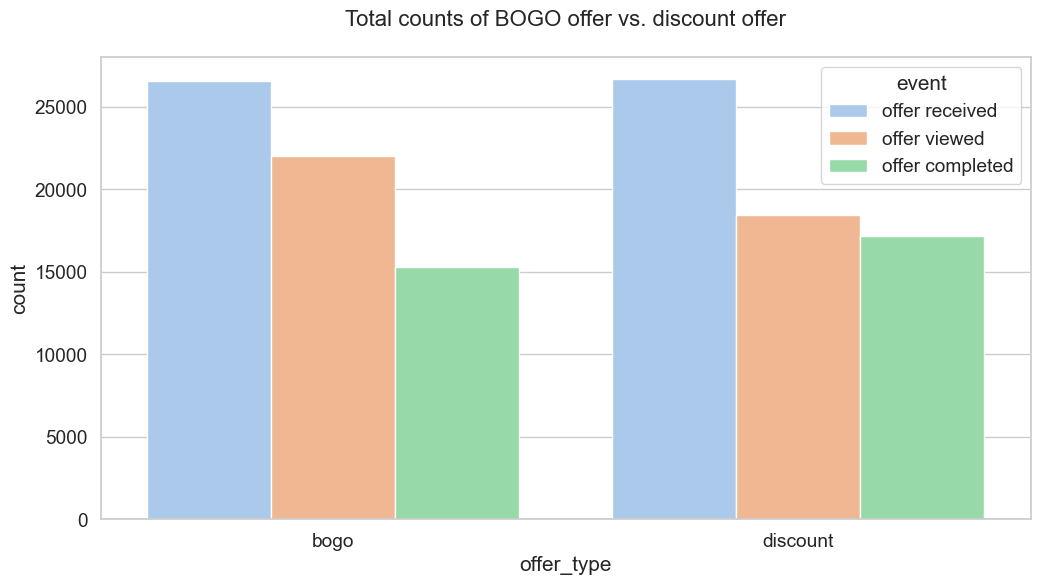

In [47]:
# for analysis lets plot graph with counts for Total counts of BOGO offer vs. discount offer
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type", hue="event", data=bogo_discount_notcleaned, palette="pastel")
plt.title("Total counts of BOGO offer vs. discount offer\n", fontsize=16);

In [48]:
def event_counts(df):
    """
    output:
    returns the counts of each individual event
    Input:
    df: dataframe
    """
    events = df['event'].unique()
    counts = []
    for event in events:
        count = len(df[df['event'] == event])
        yield count

In [49]:
#event counts of BOGO offer
bogo_received, bogo_viewed, bogo_completed = event_counts(bogo)

#event counts of discount offer
discount_received, discount_viewed, discount_completed = event_counts(discount)

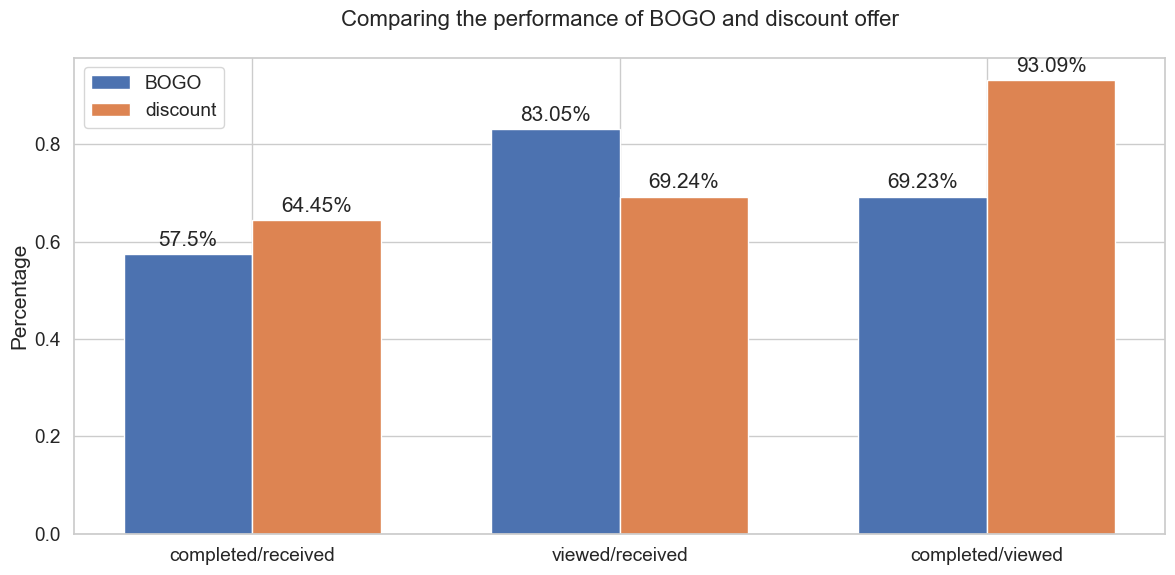

In [50]:
labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo_completed/bogo_received, bogo_viewed/bogo_received, bogo_completed/bogo_viewed]
discount_performance = [discount_completed/discount_received, discount_viewed/discount_received, discount_completed/discount_viewed]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offer\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Discount offer is more successful because**
not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers. But turning offer received to offer completed can be done by discount offer than bogo offer.

we can also check for offers that led to successful offer meaning it took following path
offer received → offer viewed → transaction(s) → offer completed

In [51]:
pd.DataFrame(full_data.groupby(['offer'])['success'].mean()).reset_index().sort_values('success', ascending=False)

,offer,success
4,discount_2_for_10_in_10days,0.691371
6,discount_3_for_7_in_7days,0.665214
8,informational_0_for_0_in_3days,0.640373
2,bogo_5_for_5_in_5days,0.563108
0,bogo_10_for_10_in_5days,0.457455
1,bogo_10_for_10_in_7days,0.435583
9,informational_0_for_0_in_4days,0.382605
3,bogo_5_for_5_in_7days,0.374869
5,discount_2_for_10_in_7days,0.367667
7,discount_5_for_20_in_10days,0.243533


**This also shows that discount offer is better performing than Bogo offer.**

# Predicting Offer Success
Having done some basic data exploration and cleaning and on the way answering few questions, Now to get a better understanding of the data, my next goal is to build a simple machine learning model to predict offer success based on the offer and customer characteristics.

Metric used are accuracy_score, roc_auc_score

In [52]:
def Classification_model(df, target, target_names,
                               model=RandomForestClassifier(max_depth=20, random_state=42)):
    '''
    Builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable
    target_names - labels for the target values
    model - the model (default: random forest classification with max tree depth of 20, random state of 42)
    
    OUTPUT:
    model - the classification model
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    model = model

    model.fit(X_train, y_train)
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions, target_names=target_names))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
    
    return model

In [53]:
overall_model_randf = Classification_model(full_data, 'success', ['failure', 'success'])

              precision    recall  f1-score   support

     failure       0.72      0.71      0.71     10390
     success       0.69      0.70      0.69      9561

    accuracy                           0.70     19951
   macro avg       0.70      0.70      0.70     19951
weighted avg       0.70      0.70      0.70     19951

Overall model accuracy:	 0.7031727732945717
Train ROC AUC score:	 0.996143780340031
Test ROC AUC score:	 0.7678192325475275


In [54]:
overall_model_gb = Classification_model(full_data, 'success', ['failure', 'success'],GradientBoostingClassifier(random_state=42))

              precision    recall  f1-score   support

     failure       0.69      0.71      0.70     10390
     success       0.68      0.66      0.67      9561

    accuracy                           0.69     19951
   macro avg       0.69      0.68      0.68     19951
weighted avg       0.69      0.69      0.69     19951

Overall model accuracy:	 0.6857300385945566
Train ROC AUC score:	 0.7545997663725021
Test ROC AUC score:	 0.7526661639426049


In [55]:
overall_model = Classification_model(full_data, 'success', ['failure', 'success'],AdaBoostClassifier(random_state=42))

              precision    recall  f1-score   support

     failure       0.68      0.68      0.68     10390
     success       0.66      0.66      0.66      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy:	 0.6710941807428199
Train ROC AUC score:	 0.7295966493333714
Test ROC AUC score:	 0.7299133701950669


In [56]:
overall_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [57]:
def most_important_features(df, model):
    '''
    identifies most important features
    
    INPUT:
    df - the dataframe used to train and test the model
    model - the classification model
    
    OUTPUT:
    feat_imp - an ordered dataframe consisting of all features and importance
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
    
    feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns,
                            columns=['importance']).sort_values('importance', ascending=False).reset_index()
    feat_imp.rename(columns={'index':'feature'},inplace=True)
    
    plot = sns.factorplot(data=feat_imp.reset_index(), y='feature', x='importance', kind='bar', aspect=2)
    plot.set(title='Feature importance')
    
    return feat_imp

C:\Users\radel\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


,feature,importance
0,membership_duration,0.24
1,income,0.16
2,age,0.14
3,duration,0.14
4,difficulty,0.06
5,reward,0.06
6,bogo,0.04
7,mobile,0.04
8,social,0.04
9,M,0.02


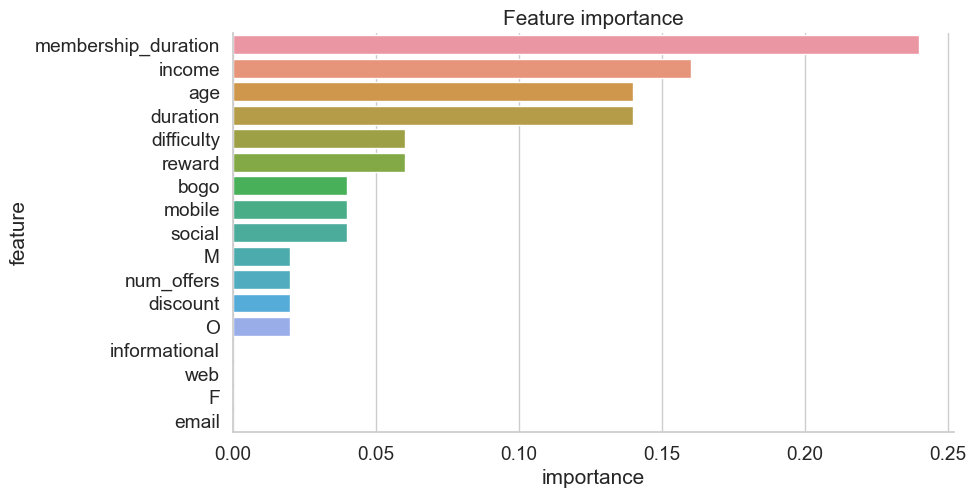

In [58]:
most_important_features(full_data, overall_model)

In [59]:
# Total number of received offers
full_data.groupby(['num_offers'])['success'].mean()

num_offers
1.0    0.532258
2.0    0.479323
3.0    0.478468
4.0    0.471573
5.0    0.487841
6.0    0.484353
Name: success, dtype: float64

Offers tend to be more successful if the total number of received offers is either very low or very high (U-shaped relationship). This may be complete coincidence.

In [60]:
full_data.groupby('success')['income'].mean()

success
0    63151.442168
1    67759.699117
Name: income, dtype: float64

Offers are more likely to be successful for members with higher incomes.

In [64]:
full_data.groupby(['social'])['success'].mean()

social
0.0    0.341923
1.0    0.575599
Name: success, dtype: float64

Offers are more likely to be successful when they are sent out via the channel 'social'.

# Conclusion

# Results
In this project, my goal was to predict offer success based on the available offer and customer information. I have built a simple classification model using a random forest classifier,GradientBoostingClassifier, AdaBoostClassifier and found out AdaBoostClassifier works for this case.

The AdaBoost classification model can be used to predict whether an offer is going to be successfully completed based on customer and offer characteristics. The final model has an accuracy of 67%, which is a decent number for business purposes, although there is certainly room for improvement.

**The most relevant factors for offer success based on the model are:**

1- Membership duration

2- Income

3- Age

4- offer Duration


In the path of building model I have raised and answer few questions like

**Which offer is the most successful?**

Discount offer is more successful because not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers. But turning offer received to offer completed can be done by discount offer than bogo offer.

**Who spends more money? male or female?**

And by graph data we can say that Female spend more money, and that can help in targeting customers for starbucks
Improvement/Future scope include:

Explore better modeling techniques and algorithms to see whether model performance can be improved in this way.
Do not drop the observations with missing values, but use some kind of imputation strategy to see whether the model can be improved this way.